In [52]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
def read_json(pth):
    assert os.path.exists(pth)
    with open(pth) as fp:
        return json.load(fp)

def to_json(obj, pth):
    with open(pth, "w") as fp:
        json.dump(obj, fp)
from collections import defaultdict
edist = lambda x1, y1, x2, y2: np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
from mpl_toolkits.mplot3d import Axes3D


ROT = lambda theta: np.array([
        [np.cos(theta), -1 * np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1],
])

V_HEIGHT = 720
V_WIDTH  = 1080


In [53]:
preds = read_json("output/1RchFn-zZDw-results.json")

print(preds[0].keys())
for pred in preds:
    print(
        pred['image_id'],
        pred['category_id'],
        np.array(pred['keypoints']).shape,
        pred['score'],
        np.array(pred['box']),
        pred['idx'],
    )
    break


dict_keys(['image_id', 'category_id', 'keypoints', 'score', 'box', 'idx'])
0.jpg 1 (51,) 3.1060922145843506 [533.31903076 268.63006592 243.50982666 263.4899292 ] 0


In [99]:
gt_labels = {
        "Nose"          : np.array([0], dtype=int),
        "LEye"          : np.array([1], dtype=int),
        "REye"          : np.array([2], dtype=int),
        "LEar"          : np.array([3], dtype=int),
        "REar"          : np.array([4], dtype=int),
        "LShoulder"     : np.array([5], dtype=int),
        "RShoulder"     : np.array([6], dtype=int),
        "LElbow"        : np.array([7], dtype=int),
        "RElbow"        : np.array([8], dtype=int),
        "LWrist"        : np.array([9], dtype=int),
        "RWrist"        : np.array([10], dtype=int),
        "LHip"          : np.array([11], dtype=int),
        "RHip"          : np.array([12], dtype=int),
        "LKnee"         : np.array([13], dtype=int),
        "RKnee"         : np.array([14], dtype=int),
        "LAnkle"        : np.array([15], dtype=int),
        "RAnkle"        : np.array([16], dtype=int),

}

joints = {
        "LArm_joint" : ["LWrist", "LElbow", "LShoulder"],
        "RArm_joint" : ["RWrist", "RElbow", "RShoulder"],
        "LLeg_joint" : ["LAnkle", "LKnee", "LHip"],
        "RLeg_joint" : ["RAnkle", "RKnee", "RHip"],
}

joint_length = {
        ("Knee", "Ankle")        : 0.0,
        ("Hip", "Knee")          : 0.0,
        ("Shoulder", "Hip")      : 0.0,
        ('Shoulder', 'Elbow')    : 0.0,
        ('Shoulder', 'Shoulder')    : 0.0,
        ('Elbow', 'Wrist')       : 0.0,
}


def joint_len(d, dir, j1, j2):
        x1, y1, _ = d[dir + j1]
        x2, y2, _ = d[dir + j2]
        return edist(x1, y1, x2, y2)



def get_max_dist(preds):
        max_dist = defaultdict(float)
        for i in range(len(preds)):
                raw_input = np.array(preds[i]['keypoints']).reshape(-1, 3)
                feat_dict = {k : (raw_input[v.item()] / 100 )  for (k, v) in gt_labels.items()}
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        feat_dict[f"C{key}"] = (feat_dict[f"L{key}"] + feat_dict[f"R{key}"]) / 2

                for dir in ['L', 'R']:
                        for (j1, j2) in list(joint_length.keys()):
                                max_dist[(dir, j1, j2)] = max(max_dist[(dir, j1, j2)], joint_len(feat_dict, dir, j1, j2))

                # max_dist[('C', "Shoulder", "Shoulder")] = max(max_dist[('C', "Shoulder", "Shoulder")], joint_len(feat_dict, "C", "Shoulder", "Shoulder") )
        d = {}
        for (j1, j2) in list(joint_length.keys()):
                d[(j1, j2)] = max(max_dist[("L", j1, j2)], max_dist[("R", j1, j2)])

        return d

def get_min_dist(preds):
        min_dist = defaultdict(lambda : float("inf"))
        for i in range(len(preds)):
                raw_input = np.array(preds[i]['keypoints']).reshape(-1, 3)
                feat_dict = {k : (raw_input[v.item()] / 100 )  for (k, v) in gt_labels.items()}
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        feat_dict[f"C{key}"] = (feat_dict[f"L{key}"] + feat_dict[f"R{key}"]) / 2

                for dir in ['L', 'R']:
                        for (j1, j2) in list(joint_length.keys()):
                                min_dist[(dir, j1, j2)] = min( 
                                        min_dist[(dir, j1, j2)],
                                        joint_len(feat_dict, dir, j1, j2)
                                )

                # min_dist[('C', "Shoulder", "Shoulder")] = max(min_dist[('C', "Shoulder", "Shoulder")], joint_len(feat_dict, "C", "Shoulder", "Shoulder") )
        d = {}
        for (j1, j2) in list(joint_length.keys()):
                d[(j1, j2)] = min(min_dist[("L", j1, j2)], min_dist[("R", j1, j2)])

        return d

get_min_dist(preds)

{('Knee', 'Ankle'): 10.282284036969337,
 ('Hip', 'Knee'): 10.28989522448199,
 ('Shoulder', 'Hip'): 10.282178334388195,
 ('Shoulder', 'Elbow'): 10.090290039093972,
 ('Shoulder', 'Shoulder'): 9.841981633854022,
 ('Elbow', 'Wrist'): 10.381480004993511}

In [94]:
class Skeleton:
        def get_angle(self, ptA, ptB, ptC):
                dist = lambda x, y: torch.dist(x, y, p=2)
                lnAB = dist(ptA, ptB)
                lnBC = dist(ptB, ptC)
                lnAC = dist(ptA, ptC)
                theta = np.arccos(((lnAB**2) + (lnBC**2) - (lnAC**2)) / (2 * lnAB * lnBC))
                return np.degrees(theta)

        def add_centroids(self, d):
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        d[f"C{key}"] = (d[f"L{key}"] + d[f"R{key}"]) / 2
                return d
                
        def add_angles(self, d):
                # Use law of cosines.
                for j, (ka, kb, kc) in joints.items():
                        d[j] = self.get_angle(d[ka], d[kb], d[kc])
                return d
        
        def calc_z_val(self, x1, y1, x2, y2, xx, yy):
                proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
                true_length = self.max_dist[(xx, yy)]
                return -1 * ((true_length ** 2) - (proj_length ** 2)) ** 0.5
                
        def calc_gamma(self, x1, y1, x2, y2, xx, yy):
                proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
                true_length = self.max_dist[(xx, yy)]
                return np.rad2deg(np.arccos(proj_length / true_length))
                # return 0
        
        def calc_dir_facing(self):
                # The Knee Angle will always be perpendicular to direction facing.
                # Get left knee angle.
                dir = "R"
                x1, y1, _ = (self.feat_dict[dir+"Hip"])
                x2, y2, _ = (self.feat_dict[dir+"Knee"])
                left_gamma = self.calc_gamma(x1, y1, x2, y2, "Hip", "Knee")
                dir = "L"
                x1, y1, _ = (self.feat_dict[dir+"Hip"])
                x2, y2, _ = (self.feat_dict[dir+"Knee"])
                right_gamma = self.calc_gamma(x1, y1, x2, y2, "Hip", "Knee")

                gamma = (left_gamma + right_gamma) / 2
                return gamma + 90


        def plot(self, plot_3d=False, save_loc=None, angle=None):
                fig = plt.figure(figsize=(12.70, 7.20))
                if plot_3d:
                        ax = fig.add_subplot(111, projection='3d')
                else:
                        ax = fig.add_subplot(111)
                ax.set_ylim([0, 7.20])
                ax.set_xlim([0, 12.70])
                if plot_3d:
                        ax.set_xlim([0, 12.70])
                        ax.set_zlim([0, 7.20])
                        ax.set_ylim([-1, 1])
                        ax.view_init(azim=90+45, elev=5)
                        if angle:
                                ax.view_init(azim=90+angle, elev=5)

                z_feat = self.to3D()

                if plot_3d:                
                        for dir in ['L', 'R']:
                                for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                                        x1, y1, z1 = (z_feat[dir+xx])
                                        x2, y2, z2 = (z_feat[dir+yy])
                                        # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                        # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                                        # y1 = abs(7.20 - y1)
                                        # y2 = abs(7.20 - y2)
                                        ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label=dir+xx+yy)

                        x1, y1, z1 = (z_feat["CHip"])
                        x2, y2, z2 = (z_feat["CShoulder"])
                        # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                        # y1 = abs(7.20 - y1)
                        # y2 = abs(7.20 - y2)
                        ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label="Spine")

                        for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                                x1, y1, z1 = (z_feat["L"+xx])
                                x2, y2, z2 = (z_feat["R"+yy])
                                print(xx, x1, x2, y1, y2, z1, z2)
                                # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                # y1 = abs(7.20 - y1)
                                # y2 = abs(7.20 - y2)
                                ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label="RL" + xx)


                ax.legend()
                if save_loc:
                        fig.savefig(save_loc)


        def to3D(self):
                z_feat = {}
                gamma = self.calc_dir_facing()
                x, y, _ = self.feat_dict["CAnkle"]
                # Assume Z value for LAnkle = 0.
                z_LAnkle = 0.0
                x_LAnkle, y_LAnkle, _ = (self.feat_dict["LAnkle"])
                z_feat['LAnkle'] = (x_LAnkle, y_LAnkle, z_LAnkle)

                # Get Z value for RAnkle
                x_RAnkle, y_RAnkle, _ = (self.feat_dict["RAnkle"])
                # z_RAnkle = (edist(x_LAnkle, y_LAnkle, x_RAnkle, y_RAnkle)) / np.cos(np.deg2rad(gamma))
                z_RAnkle = (edist(x_LAnkle, y_LAnkle, x_RAnkle, y_RAnkle)) * np.tan(np.deg2rad(gamma))
                z_feat['RAnkle'] = (x_RAnkle, y_RAnkle, z_RAnkle)

                # Get Z value for Right Knee.
                x_RKnee, y_RKnee, _ = (self.feat_dict["RKnee"])
                proj_len = edist(x_RKnee, y_RKnee, x_RAnkle, y_RAnkle)
                true_len = self.max_dist[("Knee", "Ankle")]
                z_RKnee = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RKnee'] = (x_RKnee, y_RKnee, z_RKnee + z_RAnkle)

                # Get Z value for Left Knee.
                x_LKnee, y_LKnee, _ = (self.feat_dict["LKnee"])
                proj_len = edist(x_LKnee, y_LKnee, x_LAnkle, y_LAnkle)
                true_len = self.max_dist[("Knee", "Ankle")]
                z_LKnee = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LKnee'] = (x_LKnee, y_LKnee, z_LKnee + z_LAnkle)


                # Get Z value for right hip.
                x_RHip, y_RHip, _ = (self.feat_dict["RHip"])
                proj_len = edist(x_RHip, y_RHip, x_RKnee, y_RKnee)
                true_len = self.max_dist[("Hip", "Knee")]
                z_RHip = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RHip'] = (x_RHip, y_RHip, z_RHip - z_RKnee)

                # Get Z value for left hip.
                x_LHip, y_LHip, _ = (self.feat_dict["LHip"])
                proj_len = edist(x_LHip, y_LHip, x_LKnee, y_LKnee)
                true_len = self.max_dist[("Hip", "Knee")]
                z_LHip = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LHip'] = (x_LHip, y_LHip, z_LHip - z_LKnee)
                
                # Can now infer location of center hip.
                x_CHip, y_CHip, z_CHip = (*self.feat_dict["CHip"][:2], (z_feat['LHip'][-1] + z_feat['RHip'][-1]) / 2)
                z_feat['CHip'] = (x_CHip, y_CHip, z_CHip)

                # Get Z value for center shoulder using center hip
                x_CShoulder, y_CShoulder, _ = (self.feat_dict["CShoulder"])
                proj_len = edist(x_CShoulder, y_CShoulder, x_CHip, y_CHip)
                true_len = self.max_dist[("Shoulder", "Hip")]
                z_CShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['CShoulder'] = (x_CShoulder, y_CShoulder, z_CHip + z_CShoulder)                

                # get Z value for left shoulder using center shoulder.
                x_LShoulder, y_LShoulder, _ = (self.feat_dict["LShoulder"])
                x_RShoulder, y_RShoulder, _ = (self.feat_dict["RShoulder"])
                proj_len = edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder) / 2
                true_len = self.max_dist[("Shoulder", "Shoulder")]
                z_LShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LShoulder'] = (x_LShoulder, y_LShoulder, z_feat['CShoulder'][-1] + z_LShoulder)

                # get Z value for right shoulder using center shoulder.
                proj_len = edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder) / 2
                true_len = self.max_dist[("Shoulder", "Shoulder")] / 2
                z_RShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RShoulder'] = (x_RShoulder, y_RShoulder, z_feat['CShoulder'][-1] - z_RShoulder)

                # Just to check, lets try to recover the left and right shoulder from the dir_facing
                # @TODO: Low priority

                # Get Z value for the Elbows
                x_LElbow, y_LElbow, _ = (self.feat_dict["LElbow"])
                x_RElbow, y_RElbow, _ = (self.feat_dict["RElbow"])

                proj_len = edist(x_LShoulder, y_LShoulder, x_LElbow, y_LElbow)
                true_len = self.max_dist[("Shoulder", "Elbow")]
                z_LElbow = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LElbow'] = (x_LElbow, y_LElbow, z_LShoulder + z_LElbow)

                proj_len = edist(x_RShoulder, y_RShoulder, x_RElbow, y_RElbow)
                true_len = self.max_dist[("Shoulder", "Elbow")]
                z_RElbow = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RElbow'] = (x_RElbow, y_RElbow, z_RShoulder + z_RElbow)

                # Get Z value for hands
                x_LWrist, y_LWrist, _ = (self.feat_dict["LWrist"])
                x_RWrist, y_RWrist, _ = (self.feat_dict["RWrist"])

                proj_len = edist(x_LElbow, y_LElbow, x_LWrist, y_LWrist)
                true_len = self.max_dist[("Elbow", "Wrist")]
                z_LWrist = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LWrist'] = (x_LWrist, y_LWrist, z_LElbow + z_LWrist)

                proj_len = edist(x_RElbow, y_RElbow, x_RWrist, y_RWrist)
                true_len = self.max_dist[("Elbow", "Wrist")]
                z_RWrist = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RWrist'] = (x_RWrist, y_RWrist, z_RElbow + z_RWrist)
                return z_feat

        # @TODO : scatter plot x,y values are unnormalized... Normalize datapoints before operating
        def __init__(self, arr, max_dist, min_dist):
                raw_input = np.array(arr).reshape(-1, 3)
                self.max_dist = max_dist
                process = lambda arr : np.array([arr[0] / 100, abs(V_HEIGHT - arr[1]) / 100 , arr[2] ])
                self.feat_dict = {k : ( process(raw_input[v.item()]) )  for (k, v) in gt_labels.items()}
                self.feat_dict = self.add_centroids(self.feat_dict)
                # self.feat_dict = self.add_angles(self.feat_dict)
                # print(self.feat_dict)

max_dist = get_max_dist(preds)
min_dist = get_min_dist(preds)
# Skeleton(preds[1]['keypoints']).plot()
for kp in [10, 42, 120, 210, 240]:
        print(kp)
        # Skeleton(preds[kp]['keypoints']).plot()
        # keypoints_3d = Skeleton(preds[kp]['keypoints'], max_dist).to3D() #.plot(plot_3d=True)
        Skeleton(preds[kp]['keypoints'], max_dist, min_dist).plot(plot_3d=True, angle=90)



NameError: name 'get_min_dist' is not defined

10
Hip 6.16613037109375 5.617908935546875 4.059666748046875 4.156411743164062 -1.3952177177243694 -1.6563017664635122
Shoulder 7.133580322265625 6.488613891601562 3.9306735229492187 3.9306735229492187 25.89223602504746 6.067456615322293
42
Hip 6.518563842773437 6.05185791015625 3.1207098388671874 3.093256530761719 -1.245589435475491 -1.4710187938771355
Shoulder 6.985269165039062 6.298937377929687 3.999214782714844 3.9168548583984375 26.392172002184893 6.253849740368521
120
Hip 6.376588134765625 5.87267822265625 4.043296813964844 4.043296813964844 -1.6956252123796531 -1.8109568790784092
Shoulder 6.4682080078125 5.826868286132813 5.371786346435547 5.463406372070312 24.99698004118914 6.06673429881843
210
Hip 6.670402221679687 6.175484619140625 3.5034747314453125 3.55296630859375 -1.7076598201942197 -1.8184041990552426
Shoulder 6.868368530273438 6.224976196289062 4.8892428588867185 4.8397511291503905 25.094828150029883 6.051754180267261
240
Hip 6.485938720703125 6.033391723632812 3.4426651

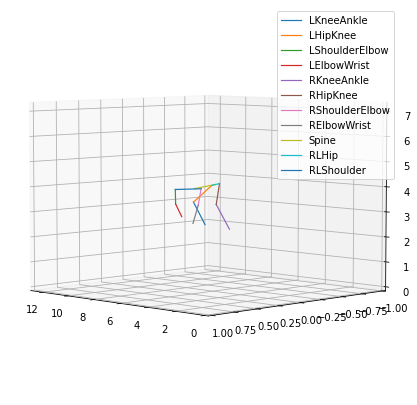

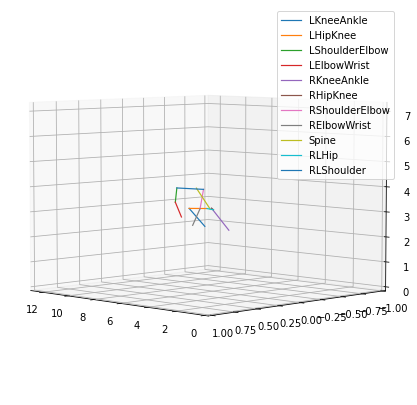

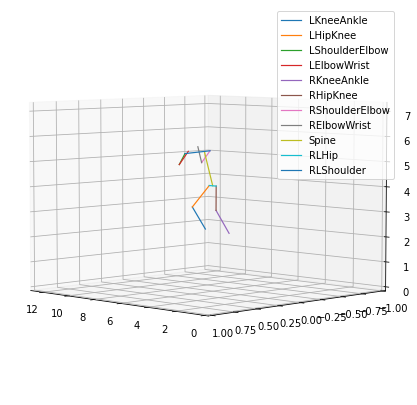

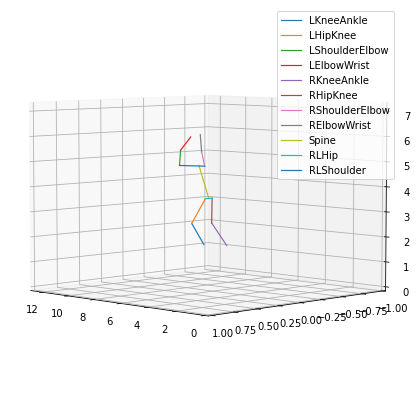

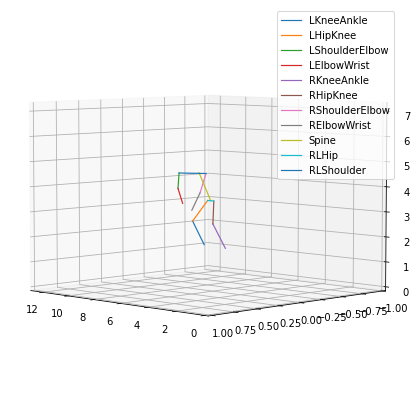

In [93]:
for kp in [10, 42, 120, 210, 240]:
        print(kp)
        # Skeleton(preds[kp]['keypoints']).plot()
        # keypoints_3d = Skeleton(preds[kp]['keypoints'], max_dist).to3D() #.plot(plot_3d=True)
        Skeleton(preds[kp]['keypoints'], max_dist).plot(plot_3d=True, angle=0)



In [ ]:
angle_space = np.linspace(0, 180, len(preds))
for kp in range(len(preds)):
    sav_loc = f"output_vid/frame_{str(kp).zfill(4)}.png"
    os.makedirs(os.path.dirname(sav_loc), exist_ok=True)
    Skeleton(preds[kp]['keypoints']).plot(plot_3d=True, save_loc=sav_loc, angle=angle_space[kp])


In [10]:

max_dist = defaultdict(float)
for i in range(len(preds)):
    s = Skeleton(preds[i]['keypoints'])
    # print(s.calc_dir_facing())
    x1, y1, _ = s.feat_dict["L" + "Shoulder"]
    x2, y2, _ = s.feat_dict["R" + "Shoulder"]
    d = edist(x1, y1, x2, y2)
    max_dist[("L", "Shoulder", "Shoulder")] = max(max_dist[("L", "Shoulder", "Shoulder")], d)


    for dir in ['L', 'R']:
            for (j1, j2) in list(joint_length.keys()) + [('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]:
                x1, y1, _ = s.feat_dict[dir + j1]
                x2, y2, _ = s.feat_dict[dir + j2]
                d = edist(x1, y1, x2, y2)
                max_dist[(dir, j1, j2)] = max(max_dist[(dir, j1, j2)], d)


# print(max_dist)
for (j1, j2) in list(joint_length.keys()) + [('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]:
    print(j1, j2, max(max_dist[("L", j1, j2)], max_dist[("R", j1, j2)]))

max_dist

Knee Ankle 20.707086450060462
Hip Knee 19.967877455300822
Shoulder Hip 19.27039065357127
Shoulder Shoulder 18.798144629570988
Shoulder Elbow 19.798114749513033
Elbow Wrist 19.626284080000794
Shoulder Elbow 19.798114749513033
Elbow Wrist 19.626284080000794


defaultdict(float,
            {('L', 'Shoulder', 'Shoulder'): 18.798144629570988,
             ('L', 'Knee', 'Ankle'): 20.535090465336825,
             ('L', 'Hip', 'Knee'): 19.757019088124395,
             ('L', 'Shoulder', 'Hip'): 19.27039065357127,
             ('L', 'Shoulder', 'Elbow'): 18.81397944806874,
             ('L', 'Elbow', 'Wrist'): 19.550269058640655,
             ('R', 'Knee', 'Ankle'): 20.707086450060462,
             ('R', 'Hip', 'Knee'): 19.967877455300822,
             ('R', 'Shoulder', 'Hip'): 19.064364176818234,
             ('R', 'Shoulder', 'Shoulder'): 18.564692810594437,
             ('R', 'Shoulder', 'Elbow'): 19.798114749513033,
             ('R', 'Elbow', 'Wrist'): 19.626284080000794})